# Applying Gradual Semantics to Causal ABA
## Confirmation of the Theory that Arrow Strengths Don't Change, Independence Fact Ranking Doesn't Change.

* Showing that the weight of the arrow assumptions is not affected by the strength of the independence assumptions and justifying it theoretically.
* Showing that the rankng of the independence assumptions does not change (for the particular experiment here) and justifying it theoretically.

The theoretical justification mentioned above involves looking at support/attack assumption sets of the assumption under consideration.

## Loading BSAF and Running Gradual ABA

Note: to be able to run this, one should navigate to notebooks/GradualSemanticsOriginal folder and run the two scripts: create_bsaf_default.py and create_bsaf_with_strengths.py:
```bash
cd notebooks/GradualSemanticsOriginal  
export PYTHONPATH=.   
python create_bsaf_default.py  
python create_bsaf_with_strengths.py 
```

The first script runs the Causal ABA with all independence assumptions having strength 0.5.   
The second script runs the Causal ABA with independence assumptions having the strength of the independence facts while dependence fact strengths are ignored.

In [1]:
import sys
import pickle
import time
import numpy as np
sys.path.insert(0, '../../')

sys.path.insert(0, '../../ArgCausalDisco/')
sys.path.insert(0, '../../notears/')
sys.path.append("../../GradualABA")

import time
from pathlib import Path
from src.utils.enums import Fact, RelationEnum
from src.utils.bn_utils import get_dataset
from ArgCausalDisco.utils.helpers import random_stability
from itertools import combinations

from ArgCausalDisco.cd_algorithms.PC import pc
from ArgCausalDisco.utils.graph_utils import initial_strength

from src.causal_aba.factory import ABASPSolverFactory

from GradualABA.ABAF import ABAF
from GradualABA.semantics.bsafDiscreteModular import DiscreteModular
from GradualABA.semantics.modular.LinearInfluence import LinearInfluence
from GradualABA.semantics.modular.ProductAggregation import ProductAggregation
from GradualABA.semantics.modular.SetProductAggregation import SetProductAggregation
from GradualABA.semantics.modular import SumAggregation
from GradualABA.semantics.modular import QuadraticMaximumInfluence


ALPHA = 0.01
INDEP_TEST = 'fisherz'

N_RUNS = 50
SAMPLE_SIZE = 5000

DELTA = 5
EPSILON = 5e-3
LOAD_FROM_FILE = False
RESULT_DIR = Path("./results/")

dataset_name = 'cancer'
seed = 2024
appendix_default = f"{dataset_name}_default"
appendix_with_strengths = f"{dataset_name}_with_strengths"

/homes/yh2024/gradual-sem-causal-aba/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:root:You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
INFO:root:You are using ``pytorch`` as the backend.


In [2]:
from matplotlib import pyplot as plt

def strengthplot(
    model,
    title="Untitled graph",
    wide=6,
    tall=4,
    cmap='turbo',
    dpi=300,
    linewidth_pt=1,
    alpha=0.5
):
    """
    Plots strength over time for each assumption in `model.graph_data`.

    model          -- a DiscreteModular (or similar) with graph_data populated
    """
    # 2) grab the time-series data
    graph_data = getattr(model, "graph_data",
                       getattr(model, "approximator", {}).get("graph_data", None))
    if not graph_data:
        raise ValueError("No graph_data found—run solve(..., generate_plot=True) first")
   
    # 4) make the axes
    fig, ax = plt.subplots(figsize=(wide, tall), dpi=dpi)
    # hide top & right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    cmap = plt.get_cmap(cmap)

    for name, seq in graph_data.items():
        xs = [t for (t, _) in seq]
        ys = [v for (_, v) in seq]
        color = cmap(ys[-1])
        ax.plot(xs, ys, label=name, color=color, alpha=alpha, linewidth=linewidth_pt)

    ax.set_xlabel("Time (t)")
    ax.set_ylabel("Strength (t)")
    ax.set_title(title)

    ax.grid()
    return plt


In [4]:
bsaf_default = pickle.load(open(RESULT_DIR / f"bsaf_{appendix_default}.pkl", "rb"))
bsaf_with_strengths = pickle.load(open(RESULT_DIR / f"bsaf_{appendix_with_strengths}.pkl", "rb"))

In [5]:
model_default_dfquad = DiscreteModular(BSAF=bsaf_default, aggregation=ProductAggregation(),                ## Attack/Support Aggregation (as per UP)
                        influence=LinearInfluence(conservativeness=1),              ## Influence (as per UP)
                        set_aggregation=SetProductAggregation())                    ## Set Attack/Support Aggregation

model_default_dfquad.solve(20, generate_plot=True, verbose=False)

per_arg_default_dfquad = model_default_dfquad.has_converged(epsilon=EPSILON, last_n=DELTA)

All assumptions have stabilized in the last 5 steps.


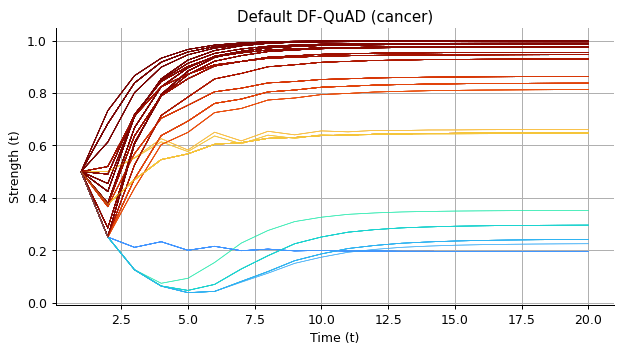

In [15]:
if model_default_dfquad.is_globally_converged(epsilon=EPSILON, last_n=DELTA):
    print("All assumptions have stabilized in the last 5 steps.")
else:
    print("Some are still oscillating or drifting.")

strengthplot(model_default_dfquad, title=f"Default DF-QuAD ({dataset_name})", linewidth_pt=0.5, tall=4, wide=8, dpi=90);

In [7]:
model_default_qe = DiscreteModular(BSAF=bsaf_default, aggregation=SumAggregation(),                   ## Attack/Support Aggregation (as per UP) 
                        influence=QuadraticMaximumInfluence(conservativeness=1),    ## Influence (as per UP)
                        set_aggregation=SetProductAggregation())                    ## Set Attack/Support Aggregation

model_default_qe.solve(20, generate_plot=True, verbose=False)

per_arg_default_qe = model_default_qe.has_converged(epsilon=EPSILON, last_n=DELTA)

Some are still oscillating or drifting.


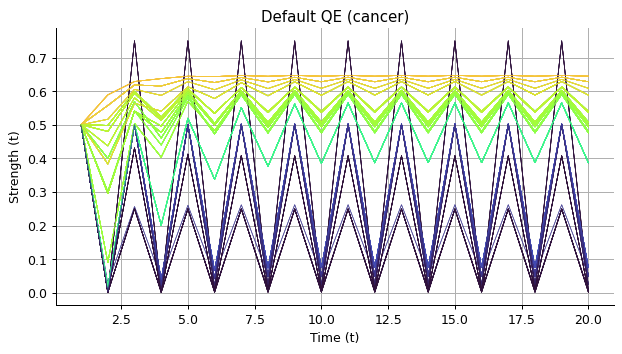

In [14]:

if model_default_qe.is_globally_converged(epsilon=EPSILON, last_n=DELTA):
    print("All assumptions have stabilized in the last 5 steps.")
else:
    print("Some are still oscillating or drifting.")

strengthplot(model_default_qe, title=f"Default QE ({dataset_name})", linewidth_pt=0.5, tall=4, wide=8, dpi=90);

In [9]:
model_with_strengths_dfquad = DiscreteModular(BSAF=bsaf_with_strengths, aggregation=ProductAggregation(),                ## Attack/Support Aggregation (as per UP)
                        influence=LinearInfluence(conservativeness=1),              ## Influence (as per UP)
                        set_aggregation=SetProductAggregation())                    ## Set Attack/Support Aggregation   

model_with_strengths_dfquad.solve(20, generate_plot=True, verbose=False)
per_arg_with_strengths_dfquad = model_with_strengths_dfquad.has_converged(epsilon=EPSILON, last_n=DELTA)


All assumptions have stabilized in the last 5 steps.


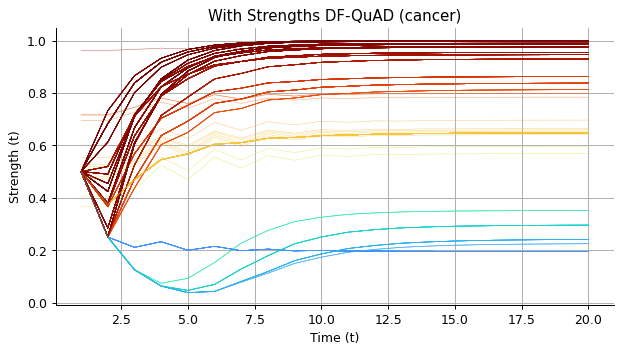

In [13]:
if model_with_strengths_dfquad.is_globally_converged(epsilon=EPSILON, last_n=DELTA):
    print("All assumptions have stabilized in the last 5 steps.")
else:
    print("Some are still oscillating or drifting.")


strengthplot(model_with_strengths_dfquad, title=f"With Strengths DF-QuAD ({dataset_name})", linewidth_pt=0.5, tall=4, wide=8, dpi=90);

In [11]:
model_with_strengths_qe = DiscreteModular(BSAF=bsaf_with_strengths, aggregation=SumAggregation(),                   ## Attack/Support Aggregation (as per UP)
                        influence=QuadraticMaximumInfluence(conservativeness=1),    ## Influence (as per UP)
                        set_aggregation=SetProductAggregation())                    ## Set Attack/Support Aggreg
model_with_strengths_qe.solve(20, generate_plot=True, verbose=False)
per_arg_with_strengt_strengthhs_qe = model_with_strengths_qe.has_converged(epsilon=EPSILON, last_n=DELTA)


Some are still oscillating or drifting.


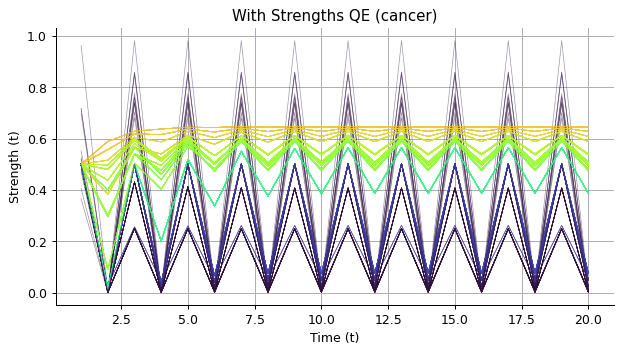

In [16]:
if model_with_strengths_qe.is_globally_converged(epsilon=EPSILON, last_n=DELTA):
    print("All assumptions have stabilized in the last 5 steps.")
else:
    print("Some are still oscillating or drifting.")


strengthplot(model_with_strengths_qe, title=f"With Strengths QE ({dataset_name})", linewidth_pt=0.5, tall=4, wide=8, dpi=90);

## Investigating Arrow and Independence Assumption Strengths and Support/Attack Sets


We will only examine DF-QuAD results because the weights for DF-QuAD semantics has converged succesfully in cotrast to QE semantics,

In [17]:
abaf_default_dfquad = pickle.load(open(RESULT_DIR / f"solver_{appendix_default}.pkl", "rb"))
abaf_with_strengths_dfquad = pickle.load(open(RESULT_DIR / f"solver_{appendix_with_strengths}.pkl", "rb"))

In [18]:
arr_default_dfquad = {name: asms for name, asms in abaf_default_dfquad.abaf.idx_to_asmpt.items()
                      if asms.startswith('arr')}
noe_default_dfquad = {name: asms for name, asms in abaf_default_dfquad.abaf.idx_to_asmpt.items()
                     if asms.startswith('noe')}

arr_ws_dfquad = {name: asms for name, asms in abaf_with_strengths_dfquad.abaf.idx_to_asmpt.items()
                 if asms.startswith('arr')}
noe_ws_dfquad = {name: asms for name, asms in abaf_with_strengths_dfquad.abaf.idx_to_asmpt.items()
                 if asms.startswith('noe')}


In [19]:
# plotting evolution of arrow strengths
def plot_strengths_given_asms(ax,
                              model,
                              name_to_label,
                              title="Untitled graph",
                              alpha=0.5,
                              cmap='turbo',
                              linewidth_pt=1,
                              ):
    graph_data = getattr(model, "graph_data",
                       getattr(model, "approximator", {}).get("graph_data", None))
    if not graph_data:
        raise ValueError("No graph_data found—run solve(..., generate_plot=True) first")

    cmap = plt.get_cmap(cmap)
    
    for name, label in name_to_label.items():
        seq = graph_data[str(name)]
        xs = [t for (t, _) in seq]
        ys = [v for (_, v) in seq]
        color = cmap(np.random.rand())
        ax.plot(xs, ys, label=label, color=color, alpha=alpha, linewidth=linewidth_pt)

    ax.set_xlabel("Time (t)")
    ax.set_ylabel("Strength (t)")
    ax.set_title(title)

    ax.grid()
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
    return plt



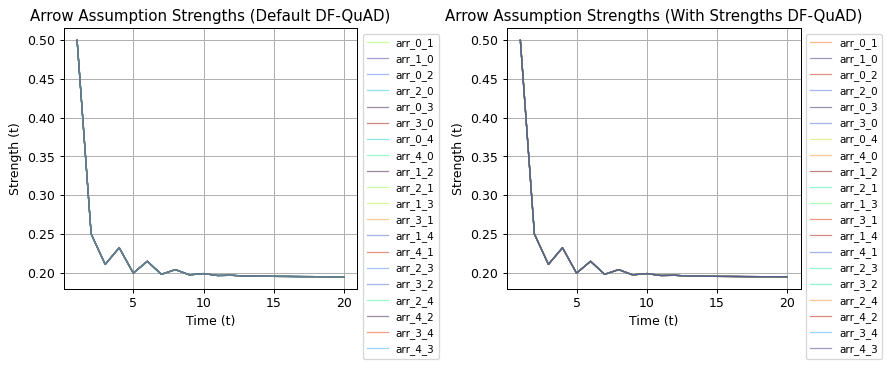

In [20]:
# 4) make the axes
wide, tall, dpi = 10, 4, 90
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(wide, tall), dpi=dpi)

plot_strengths_given_asms(ax1, model_default_dfquad, arr_default_dfquad, "Arrow Assumption Strengths (Default DF-QuAD)")
plot_strengths_given_asms(ax2, model_with_strengths_dfquad, arr_ws_dfquad, "Arrow Assumption Strengths (With Strengths DF-QuAD)")
fig.tight_layout()

**Strengths of independence assumptions have no effect on the strength of arrow assumptions**

In [21]:
# We will split independence assumptions into 2 groups:
# 1) those that correspond to independence facts
# 2) those that correspond to dependence facts

from src.causal_aba.assumptions import indep

facts_ws = pickle.load(open(RESULT_DIR / f"facts_{appendix_with_strengths}.pkl", "rb"))
indep_fact_asms = []
dep_fact_asms = []
for fact in facts_ws:
    if fact.relation == RelationEnum.indep:
        indep_fact_asms.append(indep(fact.node1, fact.node2, fact.node_set))
    elif fact.relation == RelationEnum.dep:
        dep_fact_asms.append(indep(fact.node1, fact.node2, fact.node_set))

indep_ws_dfquad = {name: asms for name, asms in abaf_with_strengths_dfquad.abaf.idx_to_asmpt.items()
                   if asms in indep_fact_asms}
dep_ws_dfquad = {name: asms for name, asms in abaf_with_strengths_dfquad.abaf.idx_to_asmpt.items()
                    if asms in dep_fact_asms}

len(dep_fact_asms), len(indep_fact_asms), len(dep_ws_dfquad), len(indep_ws_dfquad)

(32, 12, 32, 12)

<module 'matplotlib.pyplot' from '/homes/yh2024/gradual-sem-causal-aba/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

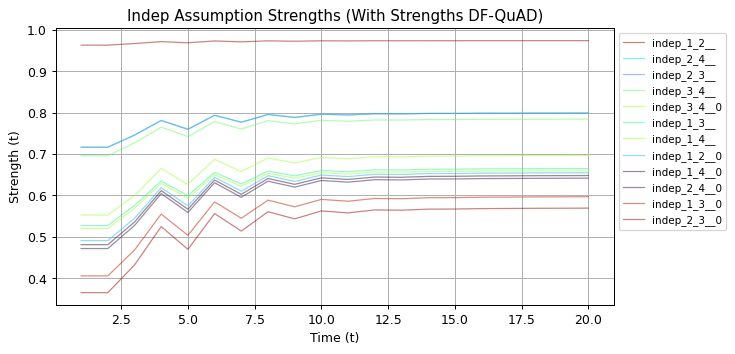

In [22]:
# 4) make the axes
wide, tall, dpi = 8, 4, 90
fig, ax = plt.subplots(figsize=(wide, tall), dpi=dpi)

plot_strengths_given_asms(ax, model_with_strengths_dfquad, indep_ws_dfquad, "Indep Assumption Strengths (With Strengths DF-QuAD)")

**Ranking of independendence assumptions did not change as expected. Let's double check it.**

In [23]:
graph_data_ws_dfquad = getattr(model_with_strengths_dfquad, "graph_data",
                               getattr(model_with_strengths_dfquad, "approximator", {}).get("graph_data", None))
indep_strengths_dfquad = {asms: graph_data_ws_dfquad[str(name)] for name, asms in indep_ws_dfquad.items()} 

In [24]:
ranking_init_strength = sorted(indep_strengths_dfquad.keys(), key=lambda x: indep_strengths_dfquad[x][0][-1], reverse=True)
ranking_final_strength = sorted(indep_strengths_dfquad.keys(), key=lambda x: indep_strengths_dfquad[x][-1][-1], reverse=True)

print('ranking is same? ', ranking_init_strength == ranking_final_strength)

ranking is same?  True


<module 'matplotlib.pyplot' from '/homes/yh2024/gradual-sem-causal-aba/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

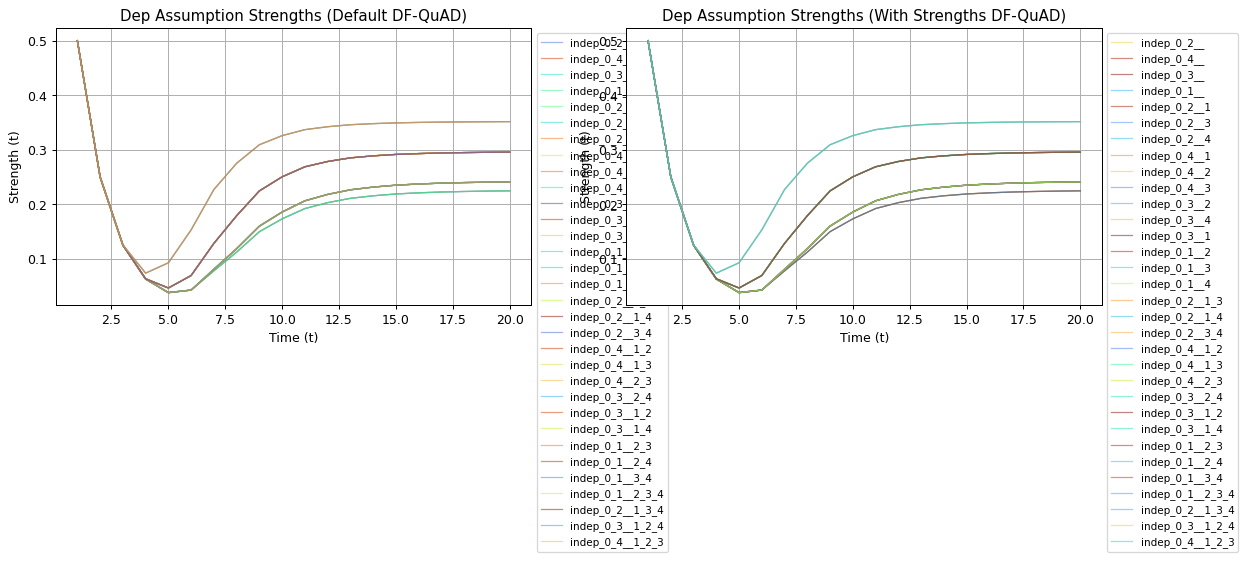

In [25]:
# 4) make the axes
wide, tall, dpi = 15, 4, 90
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(wide, tall), dpi=dpi)

plot_strengths_given_asms(ax1, model_default_dfquad, dep_ws_dfquad, "Dep Assumption Strengths (Default DF-QuAD)")
plot_strengths_given_asms(ax2, model_with_strengths_dfquad, dep_ws_dfquad, "Dep Assumption Strengths (With Strengths DF-QuAD)")


**No changes for independence assumptions corresponding to dependence facts as expected**

The ranking that has emerged above is determined by the size of their conditioning set which determined the sizes and consequently the strengths of their support and attack sets. We double check it below:

In [26]:
dep_final_strengths_dfquad = {asms: graph_data_ws_dfquad[str(name)][-1][-1] for name, asms in dep_ws_dfquad.items()} 
dep_final_strengths_dfquad_rounded = {asms: round(v, 5) for asms, v in dep_final_strengths_dfquad.items()}

In [27]:
dep_final_strengths_clusters = dict()
for asm, strength in dep_final_strengths_dfquad_rounded.items():
    res = dep_final_strengths_clusters.get(str(strength), [])
    res.append(asm)
    dep_final_strengths_clusters[str(strength)] = res

dep_final_strengths_clusters 

{'0.22453': ['indep_0_2__', 'indep_0_4__', 'indep_0_3__', 'indep_0_1__'],
 '0.24091': ['indep_0_2__1',
  'indep_0_2__3',
  'indep_0_2__4',
  'indep_0_4__1',
  'indep_0_4__2',
  'indep_0_4__3',
  'indep_0_3__2',
  'indep_0_3__4',
  'indep_0_3__1',
  'indep_0_1__2',
  'indep_0_1__3',
  'indep_0_1__4'],
 '0.29557': ['indep_0_2__1_3',
  'indep_0_2__1_4',
  'indep_0_2__3_4',
  'indep_0_4__1_2',
  'indep_0_4__1_3',
  'indep_0_4__2_3',
  'indep_0_3__2_4',
  'indep_0_3__1_2',
  'indep_0_3__1_4',
  'indep_0_1__2_3',
  'indep_0_1__2_4',
  'indep_0_1__3_4'],
 '0.35148': ['indep_0_1__2_3_4',
  'indep_0_2__1_3_4',
  'indep_0_3__1_2_4',
  'indep_0_4__1_2_3']}

**So the strength evolution only happens due to size of conditioning set and not in the way we would like: bigger conditioning set results in greater strength while ideally it should be the opposite.**

**The experiment of only using the p-value and ignoring the conditioning set size is out of question as it does not make sense if this is the case.**

## Theoretical Justification

In this section we'll look at BSAF support and attack sets of arrow and independence assumptions to confirm that their strength did not have any chance to evolve.

In [28]:
def get_support_and_atack(bsaf, abaf, asms_name):
    index = abaf.asmpt_to_idx[asms_name]
    support = next(v for k, v in bsaf.supports.items() if k.name == str(index))
    attack = next(v for k, v in bsaf.attacks.items() if k.name == str(index))
    all_support = set()
    all_attack = set()
    for s_set in support:
        for s in s_set:
            all_support.add(abaf.idx_to_asmpt[int(s.name)])
    for a_set in attack:
        for a in a_set:
            all_attack.add(abaf.idx_to_asmpt[int(a.name)])
    return all_support, all_attack



In [29]:
arr_supports, arr_attacks = dict(), dict()
for _, arr in arr_ws_dfquad.items():
    arr_supports[arr], arr_attacks[arr] = get_support_and_atack(bsaf_with_strengths, abaf_with_strengths_dfquad.abaf, arr)

noe_supports, noe_attacks = dict(), dict()
for _, noe in noe_ws_dfquad.items():
    noe_supports[noe], noe_attacks[noe] = get_support_and_atack(bsaf_with_strengths, abaf_with_strengths_dfquad.abaf, noe)

In [30]:
arr_supports

{'arr_0_1': {'arr_0_1'},
 'arr_1_0': {'arr_1_0'},
 'arr_0_2': {'arr_0_2'},
 'arr_2_0': {'arr_2_0'},
 'arr_0_3': {'arr_0_3'},
 'arr_3_0': {'arr_3_0'},
 'arr_0_4': {'arr_0_4'},
 'arr_4_0': {'arr_4_0'},
 'arr_1_2': {'arr_1_2'},
 'arr_2_1': {'arr_2_1'},
 'arr_1_3': {'arr_1_3'},
 'arr_3_1': {'arr_3_1'},
 'arr_1_4': {'arr_1_4'},
 'arr_4_1': {'arr_4_1'},
 'arr_2_3': {'arr_2_3'},
 'arr_3_2': {'arr_3_2'},
 'arr_2_4': {'arr_2_4'},
 'arr_4_2': {'arr_4_2'},
 'arr_3_4': {'arr_3_4'},
 'arr_4_3': {'arr_4_3'}}

In [31]:
noe_supports

{'noe_0_1': {'noe_0_1'},
 'noe_0_2': {'noe_0_2'},
 'noe_0_3': {'noe_0_3'},
 'noe_0_4': {'noe_0_4'},
 'noe_1_2': {'noe_1_2'},
 'noe_1_3': {'noe_1_3'},
 'noe_1_4': {'noe_1_4'},
 'noe_2_3': {'noe_2_3'},
 'noe_2_4': {'noe_2_4'},
 'noe_3_4': {'noe_3_4'}}

Arrows and no-edge assumptions are not derived by any rule so it was expected that they are supported by only the generic argument of self-derivation.

In [32]:
# Here we check that arrows are only attacked by other arrows and noedge assumptions.
all_arr_attacks = set()
for att in arr_attacks.values():
    all_arr_attacks.update(att)

all(att.startswith('arr') or att.startswith('noe') for att in all_arr_attacks)

True

In [33]:
# Same for noedge assumptions

all_noe_attacks = set()
for att in noe_attacks.values():
    all_noe_attacks.update(att)

all(att.startswith('arr') or att.startswith('noe') for att in all_noe_attacks)

True

One more check to confirm that the independence assumptions are not included in any support or attack set whatsoever.

In [34]:
all_attacks = set()

for a_set_of_sets in bsaf_with_strengths.attacks.values():
    for a_set in a_set_of_sets:
        for a in a_set:
            asms = abaf_with_strengths_dfquad.abaf.idx_to_asmpt[int(a.name)]
            all_attacks.add(asms)

all_supports = set()
indep_generic_arguments = []
for key, s_set_of_sets in bsaf_with_strengths.supports.items():
    for s_set in s_set_of_sets:
        # check if generic argument (indep |- indep)
        if len(s_set) == 1 and key == list(s_set)[0]:
            # is generic argument
            continue

        for s in s_set:
            asms = abaf_with_strengths_dfquad.abaf.idx_to_asmpt[int(s.name)]
            all_supports.add(asms)

In [35]:
any(asms.startswith('indep') for asms in all_attacks), any(asms.startswith('indep') for asms in all_supports)

(False, False)

The check above proves that there are no assumptions (except for generic ones [indep |- indep]) that have an independence assumption in their support or attack sets.